In [26]:
import os
import joblib
import torch
import yaml
import zipfile
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [27]:
with open("../../default_params.yml", "r") as file:
    config = yaml.safe_load(file)
    
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"

In [ ]:
class Loader:
    def __init__(self, dataset=None, batch_size=24, normalized=True):
        self.dataset = dataset
        self.batch_size = config["dataloader"]["batch_size"]
        self.val_batch_size = batch_size
        self.image_height = config["dataloader"]["image_height"]
        self.image_width = config["dataloader"]["image_width"]
        self.normalized = normalized
        self.p_value = 0.5
        self.normalized_value = 0.5

    def unzip_folder(self):
        with zipfile.ZipFile(self.dataset, "r") as zip_ref:
            if os.path.exists(RAW_DATA_PATH):
                zip_ref.extractall(RAW_DATA_PATH)
            else:
                raise Exception("Could not find the raw data folder".title())

    def _normalized(self):
        return transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((self.image_height, self.image_width)),
                transforms.CenterCrop((self.image_height, self.image_width)),
                transforms.RandomVerticalFlip(p=self.p_value),
                transforms.Normalize(
                    mean=[
                        self.normalized_value,
                        self.normalized_value,
                        self.normalized_value,
                    ],
                    std=[
                        self.normalized_value,
                        self.normalized_value,
                        self.normalized_value,
                    ],
                ),
            ]
        )

    def create_dataloader(self):
        if os.path.exists(RAW_DATA_PATH):
            dataset = ImageFolder(root=RAW_DATA_PATH, transform=self._normalized())
            dataloader = DataLoader(
                dataset=dataset, batch_size=self.batch_size, shuffle=True
            )

            if os.path.exists(PROCESSED_DATA_PATH):
                joblib.dump(
                    value=dataloader,
                    filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"),
                )
            else:
                raise Exception("Could not find the processed data folder".title())

            return dataloader
        else:
            raise Exception("Could not find the raw data folder".title())


if __name__ == "__main__":
    loader = Loader(
        dataset="./data.zip",
        batch_size=24,
        normalized=True,
    )

    loader.unzip_folder()

    dataloader = loader.create_dataloader()

In [30]:
sum(data.size(0) for data, _ in dataloader)

/Users/shahmuhammadraditrahman/anaconda3/envs/GPSG/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2194

In [31]:
data, _ = next(iter(dataloader))

data.shape

/Users/shahmuhammadraditrahman/anaconda3/envs/GPSG/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 512])

In [33]:
inputs = data[:, :, :, :256]
targets = data[:, :, :, 256:]

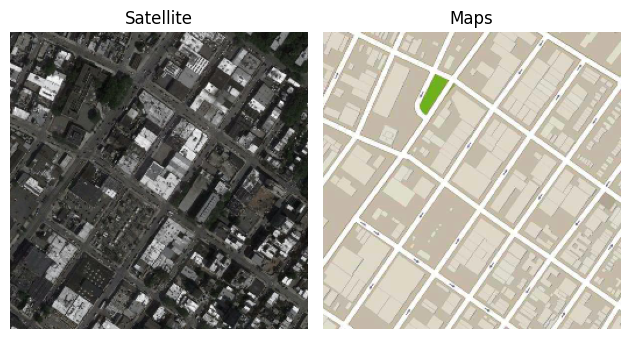

In [51]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

inputs = (inputs - inputs.min())/(inputs.max() - inputs.min())
targets = (targets - targets.min())/(targets.max() - targets.min())

plt, axes = plt.subplots(1, 2)

axes[0].imshow(inputs[0].permute(1, 2, 0))
axes[0].set_title("Satellite")
axes[0].set_axis_off()

axes[1].imshow(targets[0].permute(1, 2, 0))
axes[1].set_axis_off()
axes[1].set_title("Maps")

plt.tight_layout()
plt.show()